<a href="https://colab.research.google.com/github/ihabiba/DataMining-OnlineLearning/blob/main/Time_Series_%26_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries**

In [15]:
import warnings; warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from pmdarima.arima import auto_arima

# Make plots square and consistent
np.random.seed(42)
plt.rcParams['figure.figsize'] = (6,6)

# **STEP 1: Load Dataset**

In [2]:
# Import libraries
import pandas as pd

# Load dataset
df = pd.read_csv("personalized_learning_dataset.csv")

# Show dataset shape
print("Dataset shape:", df.shape)

print(df.dtypes)

# Display first 5 rows
df.head()

Dataset shape: (10000, 15)
Student_ID                    object
Age                            int64
Gender                        object
Education_Level               object
Course_Name                   object
Time_Spent_on_Videos           int64
Quiz_Attempts                  int64
Quiz_Scores                    int64
Forum_Participation            int64
Assignment_Completion_Rate     int64
Engagement_Level              object
Final_Exam_Score               int64
Learning_Style                object
Feedback_Score                 int64
Dropout_Likelihood            object
dtype: object


,Student_ID,Age,Gender,Education_Level,Course_Name,Time_Spent_on_Videos,Quiz_Attempts,Quiz_Scores,Forum_Participation,Assignment_Completion_Rate,Engagement_Level,Final_Exam_Score,Learning_Style,Feedback_Score,Dropout_Likelihood
0,S00001,15,Female,High School,Machine Learning,171,4,67,2,89,Medium,51,Visual,1,No
1,S00002,49,Male,Undergraduate,Python Basics,156,4,64,0,94,Medium,92,Reading/Writing,5,No
2,S00003,20,Female,Undergraduate,Python Basics,217,2,55,2,67,Medium,45,Reading/Writing,1,No
3,S00004,37,Female,Undergraduate,Data Science,489,1,65,43,60,High,59,Visual,4,No
4,S00005,34,Female,Postgraduate,Python Basics,496,3,59,34,88,Medium,93,Visual,3,No


# **STEP 2: Build a time series from the dataset**

In [3]:
# This dataset has no real date/time column. We'll create a *cohort week* index
# by batching consecutive students into "weeks" and aggregating a KPI per week.
# KPI chosen: weekly mean Final_Exam_Score

TARGET = "Final_Exam_Score"
GROUP_SIZE = 100
START_DATE = "2021-01-04"

# Assign cohort week numbers by row order:
n = len(df)
week_id = np.arange(n) // GROUP_SIZE
n_weeks = week_id.max() + 1

# Create a synthetic weekly date index:
week_dates = pd.date_range(START_DATE, periods=n_weeks, freq="W-MON")

# Aggregate the KPI per week:
ts = (
    pd.DataFrame({"week_id": week_id, TARGET: df[TARGET].values})
      .groupby("week_id")[TARGET].mean()
      .to_frame("value")
      .assign(date=lambda d: week_dates)
      .set_index("date")
      .sort_index()
)

print(ts.shape)
ts.head()


(100, 1)


,value
date,
2021-01-04,65.40
2021-01-11,68.94
2021-01-18,63.72
2021-01-25,62.75
2021-02-01,64.97


# **STEP 3: Quick sanity plot of the time series (weekly KPI)**

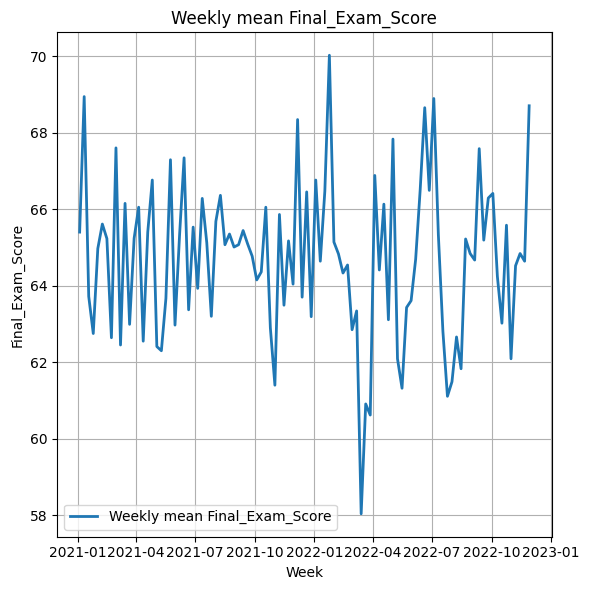

In [4]:
plt.plot(ts.index, ts["value"].values, label="Weekly mean " + TARGET, linewidth=2)
plt.title(f"Weekly mean {TARGET}")
plt.xlabel("Week"); plt.ylabel(TARGET)
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()


# **STEP 4: Feature Engineering (Lags & Rolling Mean)**

In [5]:
# Create lag_1 ... lag_7 and a 7-week rolling average to give models recent context.

data_ml = ts.copy()
for lag in range(1, 8):
    data_ml[f"lag_{lag}"] = data_ml["value"].shift(lag)

data_ml["rollmean_7"] = data_ml["value"].rolling(7).mean()

# Drop rows that can't have full lag/rolling history
data_ml = data_ml.dropna()
print(data_ml.shape)
data_ml.head()


(93, 9)


,value,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rollmean_7
date,,,,,,,,,
2021-02-22,62.64,65.23,65.61,64.97,62.75,63.72,68.94,65.40,64.837143
2021-03-01,67.60,62.64,65.23,65.61,64.97,62.75,63.72,68.94,64.645714
2021-03-08,62.45,67.60,62.64,65.23,65.61,64.97,62.75,63.72,64.464286
2021-03-15,66.15,62.45,67.60,62.64,65.23,65.61,64.97,62.75,64.950000
2021-03-22,62.99,66.15,62.45,67.60,62.64,65.23,65.61,64.97,64.667143


# **STEP 5: Train-Test Split**

In [6]:
split_idx = int(len(data_ml) * 0.8)
train = data_ml.iloc[:split_idx].copy()
test  = data_ml.iloc[split_idx:].copy()

X_train = train.drop(columns=["value"])
y_train = train["value"]
X_test  = test.drop(columns=["value"])
y_test  = test["value"]

X_train.shape, X_test.shape


((74, 8), (19, 8))

# **STEP 6: Baseline Model (Lag-1)**

In [7]:
# Baseline predicts today's value = yesterday's (lag_1) — the standard persistence rule.
y_pred_b = test["lag_1"].values
mse_b = mean_squared_error(y_test, y_pred_b)
mae_b = mean_absolute_error(y_test, y_pred_b)
print(f"Baseline (lag_1)  MSE: {mse_b:,.2f} | MAE: {mae_b:,.2f}")


Baseline (lag_1)  MSE: 4.19 | MAE: 1.63


# **STEP 7: Evaluate Random Forest and Gradient Boosting models**

In [8]:
# Initialize models: Random Forest and Gradient Boosting
rf  = RandomForestRegressor(n_estimators=300, random_state=42)
gbr = GradientBoostingRegressor(n_estimators=300, random_state=42)

# Fit models on training data and generate predictions on test set
rf.fit(X_train, y_train);   rf_pred  = rf.predict(X_test)
gbr.fit(X_train, y_train);  gbr_pred = gbr.predict(X_test)

# Define a helper function to compute error metrics (MSE & MAE)
def metrics(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{name:16s}  MSE: {mse:,.2f} | MAE: {mae:,.2f}")

# Compare Baseline vs Random Forest vs Gradient Boosting
print("\n== Errors on the same test window ==")
metrics("Baseline (lag_1)", y_test.values, y_pred_b)
metrics("RandomForest",    y_test.values, rf_pred)
metrics("GradBoosting",    y_test.values, gbr_pred)



== Errors on the same test window ==
Baseline (lag_1)  MSE: 4.19 | MAE: 1.63
RandomForest      MSE: 2.87 | MAE: 1.44
GradBoosting      MSE: 2.39 | MAE: 1.29


# **STEP 8: Plot Actual vs RF/GB predictions**

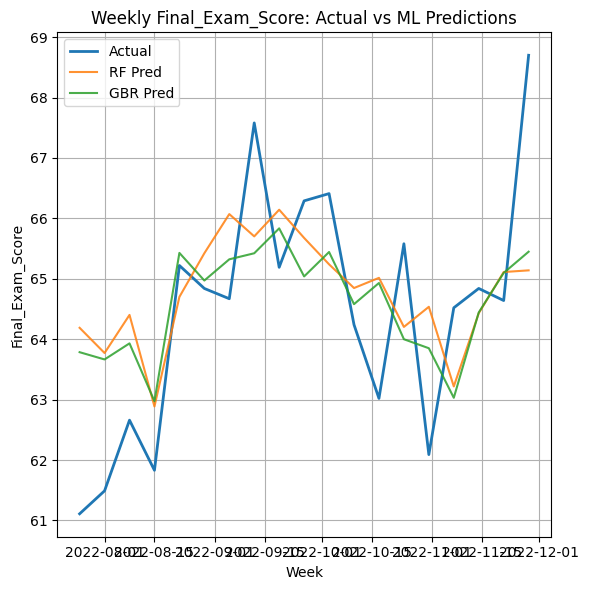

In [9]:
plt.figure(figsize=(6,6))
plt.plot(y_test.index, y_test.values, label="Actual", linewidth=2)
plt.plot(y_test.index, rf_pred, label="RF Pred", alpha=0.85)
plt.plot(y_test.index, gbr_pred, label="GBR Pred", alpha=0.85)
plt.title(f"Weekly {TARGET}: Actual vs ML Predictions")
plt.xlabel("Week"); plt.ylabel(TARGET)
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()


# **STEP 9: LSTM: sequence prep**

In [10]:
# We'll use T=8 (last 8 weeks to predict next week), which suits short weekly series.

series = ts["value"].values.reshape(-1, 1)

scaler = MinMaxScaler()
scaled = scaler.fit_transform(series)

def make_sequences(a, T=8):
    X, y = [], []
    for i in range(len(a) - T):
        X.append(a[i:i+T, 0])  # last T weeks
        y.append(a[i+T, 0])    # next week
    return np.array(X), np.array(y)

T = 8
X_seq, y_seq = make_sequences(scaled, T)
X_seq = X_seq.reshape((X_seq.shape[0], X_seq.shape[1], 1))

# time-aware 80/20 split on sequences
split_idx_l = int(len(X_seq) * 0.8)
X_train_l, X_test_l = X_seq[:split_idx_l],  X_seq[split_idx_l:]
y_train_l, y_test_l = y_seq[:split_idx_l],  y_seq[split_idx_l:]

print("LSTM shapes →", "X_train:", X_train_l.shape, "| X_test:", X_test_l.shape)


LSTM shapes → X_train: (73, 8, 1) | X_test: (19, 8, 1)


# **STEP 10: Build & train LSTM**

In [11]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(T, 1)),
    LSTM(64),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")

hist = model.fit(X_train_l, y_train_l, epochs=10, batch_size=16, verbose=0)
print("Training done.")


Training done.


# **STEP 11: LSTM Prediction & Evaluation**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
LSTM            MSE: 5.73 | MAE: 1.99


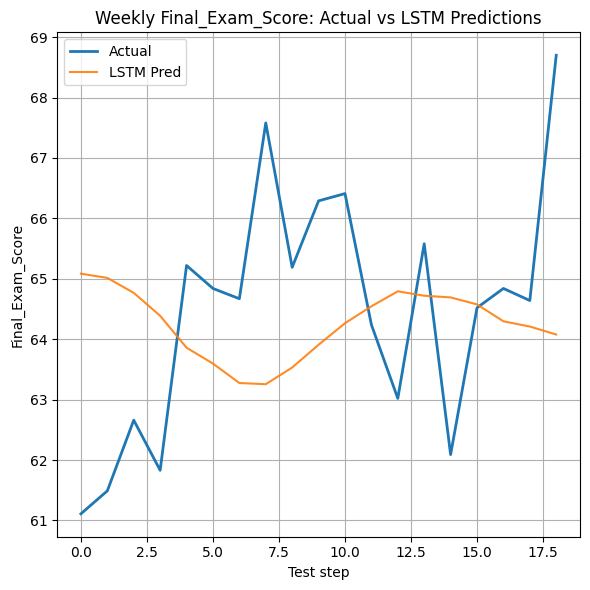

In [12]:
y_pred_l = model.predict(X_test_l)

# Back to original scale
y_pred_inv = scaler.inverse_transform(y_pred_l)
y_test_inv = scaler.inverse_transform(y_test_l.reshape(-1, 1))

mse_l = mean_squared_error(y_test_inv, y_pred_inv)
mae_l = mean_absolute_error(y_test_inv, y_pred_inv)
print(f"LSTM            MSE: {mse_l:,.2f} | MAE: {mae_l:,.2f}")

plt.figure(figsize=(6,6))
plt.plot(y_test_inv, label="Actual", linewidth=2)
plt.plot(y_pred_inv, label="LSTM Pred", alpha=0.9)
plt.title(f"Weekly {TARGET}: Actual vs LSTM Predictions")
plt.xlabel("Test step"); plt.ylabel(TARGET)
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()


## **STEP 12: AutoARIMA Model**

In [14]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 8.4 MB/s eta 0:00:00


In [16]:
# AutoARIMA works best on the raw time series, without engineered features.
# We need to split the original `ts` (time series) into training and testing sets.
# The split point should match the other models' test set.

# `ts` has 100 entries. `data_ml` (used by RF/GB) drops the first 7 entries for lags.
# `split_idx` for `data_ml` was 74. So, `74 + 7 = 81` is the equivalent split for `ts`.

# Split `ts` into training and testing sets
train_arima = ts.iloc[:81]["value"]
test_arima = ts.iloc[81:]["value"]

print(f"ARIMA train size: {len(train_arima)}")
print(f"ARIMA test size: {len(test_arima)}")

# Fit AutoARIMA model
# We'll use a relatively short test set, so fitting can be done in two ways:
# 1. Fit on `train_arima` and predict for `len(test_arima)` steps ahead.
# 2. Re-fit the model iteratively as new data comes in (more robust for production).
# For this demonstration, we'll use approach 1 for simplicity.

print("Fitting AutoARIMA... This may take a moment.")
model_arima = auto_arima(train_arima, seasonal=True, m=7,  # m=7 for weekly seasonality
                          trace=False, error_action='ignore',
                          suppress_warnings=True, stepwise=True)
print("AutoARIMA fitting complete.")

# Make predictions
y_pred_a = model_arima.predict(n_periods=len(test_arima))

# Calculate metrics
mse_a = mean_squared_error(test_arima, y_pred_a)
mae_a = mean_absolute_error(test_arima, y_pred_a)
print(f"AutoARIMA           MSE: {mse_a:,.2f} | MAE: {mae_a:,.2f}")

ARIMA train size: 81
ARIMA test size: 19
Fitting AutoARIMA... This may take a moment.
AutoARIMA fitting complete.
AutoARIMA           MSE: 4.05 | MAE: 1.53


# **STEP 13: Compare all models**


== Model comparison ==
              Model       MSE       MAE
0  Baseline (lag_1)  4.190742  1.631053
1      RandomForest  2.872591  1.444605
2      GradBoosting  2.388907  1.287607
3              LSTM  5.730114  1.992923
4         AutoARIMA  4.054413  1.533177


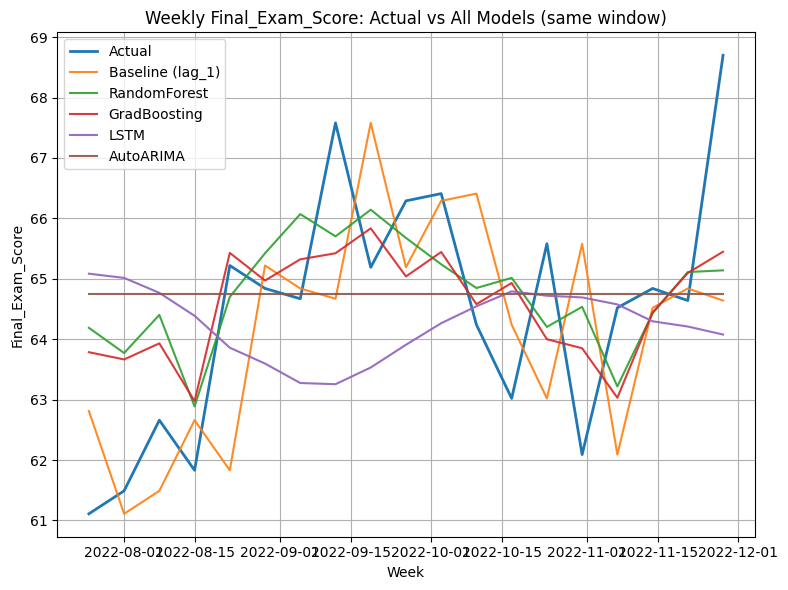

In [17]:
results = pd.DataFrame({
    "Model": ["Baseline (lag_1)", "RandomForest", "GradBoosting", "LSTM", "AutoARIMA"],
    "MSE":   [mean_squared_error(y_test.values, y_pred_b),
              mean_squared_error(y_test.values, rf_pred),
              mean_squared_error(y_test.values, gbr_pred),
              mse_l,
              mse_a],
    "MAE":   [mean_absolute_error(y_test.values, y_pred_b),
              mean_absolute_error(y_test.values, rf_pred),
              mean_absolute_error(y_test.values, gbr_pred),
              mae_l,
              mae_a]
})
print("\n== Model comparison ==")
print(results)

# Plot Actual vs all models on the SAME last n_lstm weeks
n = len(y_test_inv) # Define n_lstm as the number of test predictions for LSTM
idx = y_test.index[-n:]                         # common index for all lines

plt.figure(figsize=(8,6))

# Actual
plt.plot(idx, y_test.values[-n:], label="Actual", linewidth=2)

# Baseline / RF / GBR (slice to last n points)
plt.plot(idx, y_pred_b[-n:], label="Baseline (lag_1)", alpha=0.9)
plt.plot(idx, rf_pred[-n:], label="RandomForest", alpha=0.9)
plt.plot(idx, gbr_pred[-n:], label="GradBoosting", alpha=0.9)

# LSTM (already length n); flatten to 1-D
plt.plot(idx, y_pred_inv.ravel(), label="LSTM", alpha=0.95)

# AutoARIMA (slice to last n points)
plt.plot(idx, y_pred_a[-n:], label="AutoARIMA", alpha=0.9)

plt.title(f"Weekly {TARGET}: Actual vs All Models (same window)")
plt.xlabel("Week"); plt.ylabel(TARGET)
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()